G05: Jakober, Winkler, Matzinger, Salzmann

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib import cm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [2]:
print(f'Your torch version is {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

Your torch version is 2.6.0


device(type='mps')

### Load the data

In [3]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,                    
    transform = ToTensor(), 
    download = True,            
)

test_data = datasets.FashionMNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor(),
    download = True
)

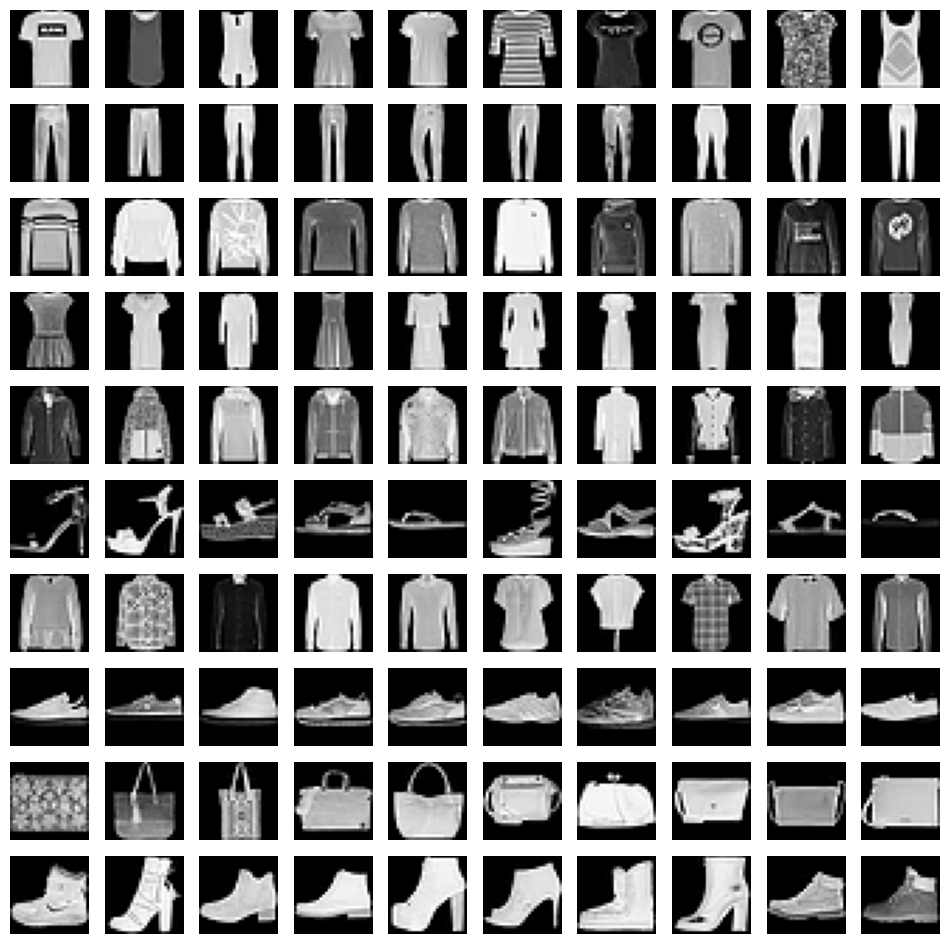

Training input shape :  (60000, 28, 28)
Training output shape:  (60000,)
Testing input shape  :  torch.Size([10000, 28, 28])
Testing output shape :  10000


In [4]:
def show_imgs(X, y):
    """Display a 10x10 grid of images, grouped by class."""
    plt.figure(1, figsize=(12,12))
    
    for i in range(10):
        class_indices = np.where(y == i)[0]
        selected_indices = class_indices[:10]
        
        for j, idx in enumerate(selected_indices):
            plt.subplot(10, 10, i * 10 + j + 1)
            plt.imshow(X[idx], cmap='gray')
            plt.axis('off')
            
    plt.show()

X_train = np.array(train_data.data)
y_train = np.array(train_data.targets)

show_imgs(X_train, y_train)

print('Training input shape : ', X_train.shape)
print('Training output shape: ', y_train.shape) 
print('Testing input shape  : ', test_data.data.shape)
print('Testing output shape : ', len(test_data.targets))

In [5]:
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

### Define the network

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [7]:
summary(CNN())

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─Conv2d: 1-3                            9,248
├─MaxPool2d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            15,690
Total params: 34,506
Trainable params: 34,506
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─Conv2d: 1-3                            9,248
├─MaxPool2d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            15,690
Total params: 34,506
Trainable params: 34,506
Non-trainable params: 0

### Training Loop

In [8]:
def run_epoch(model, dataloader, optimizer, criterion, train=True):
    """
    Runs one epoch for training or validation.
    """
    epoch_loss = 0
    correct = 0
    total_samples = len(dataloader.dataset)

    if train:
        model.train()
    else:
        model.eval()

    for X, y in tqdm(dataloader, desc=f'{"Train" if train else "Val"} Epoch'):
        X, y = X.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            output = model(X)
            loss = criterion(output, y)

        epoch_loss += loss.item()
        _, y_pred = torch.max(output, dim=1)
        correct += torch.sum(y_pred == y).item()

        if train:
            loss.backward()
            optimizer.step()

    avg_loss = epoch_loss / len(dataloader)
    accuracy = correct / total_samples

    return avg_loss, accuracy

def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    """
    Trains and evaluates the model for n_epochs.
    """
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    for epoch in range(n_epochs):

        print(f'\nEpoch {epoch+1}/{n_epochs}')
        print('----------')

        train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, train=True)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer, criterion, train=False)
            
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_train_accs.append(train_acc)
        epoch_val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}\nVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    
    return epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs

### Validation

In [9]:
def eval(model, test_loader, criterion):
    """
    Evaluates the model on the test set.
    """
    epoch_loss = 0
    correct = 0
    y_preds = []

    model.eval()
    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            output = model(X_test)
            loss = criterion(output, y_test)
            epoch_loss += loss.item()

            _, y_pred = torch.max(output, dim=1)
            y_preds.append(y_pred.cpu())
            correct += torch.sum(y_pred == y_test).item()
        
        epoch_loss /= len(test_loader)
        accuracy = correct / len(test_loader.dataset)
    
    y_preds = torch.cat(y_preds).numpy()

    return epoch_loss, accuracy, y_preds

### Plot Training Curves

In [10]:
def plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6), layout='tight')

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_xticks(range(1, n_epochs+1))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_xticks(range(1, n_epochs+1))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()

    fig.suptitle('Train/Val Losses and Accuracies')
    plt.show()


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 113.83it/s]


Train Loss: 0.5606, Train Accuracy: 0.7966
Val Loss: 0.3673, Val Accuracy: 0.8635

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 117.34it/s]


Train Loss: 0.3434, Train Accuracy: 0.8762
Val Loss: 0.2993, Val Accuracy: 0.8917

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 100.53it/s]


Train Loss: 0.2929, Train Accuracy: 0.8951
Val Loss: 0.2767, Val Accuracy: 0.8989

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 107.66it/s]


Train Loss: 0.2657, Train Accuracy: 0.9043
Val Loss: 0.2516, Val Accuracy: 0.9103

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 117.41it/s]


Train Loss: 0.2435, Train Accuracy: 0.9133
Val Loss: 0.2551, Val Accuracy: 0.9085

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 122.61it/s]


Train Loss: 0.2273, Train Accuracy: 0.9192
Val Loss: 0.2501, Val Accuracy: 0.9120

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 125.78it/s]


Train Loss: 0.2141, Train Accuracy: 0.9233
Val Loss: 0.2180, Val Accuracy: 0.9236

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 122.15it/s]


Train Loss: 0.2003, Train Accuracy: 0.9279
Val Loss: 0.2255, Val Accuracy: 0.9205

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 106.05it/s]


Train Loss: 0.1892, Train Accuracy: 0.9325
Val Loss: 0.2164, Val Accuracy: 0.9238

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 106.56it/s]


Train Loss: 0.1771, Train Accuracy: 0.9355
Val Loss: 0.2112, Val Accuracy: 0.9252


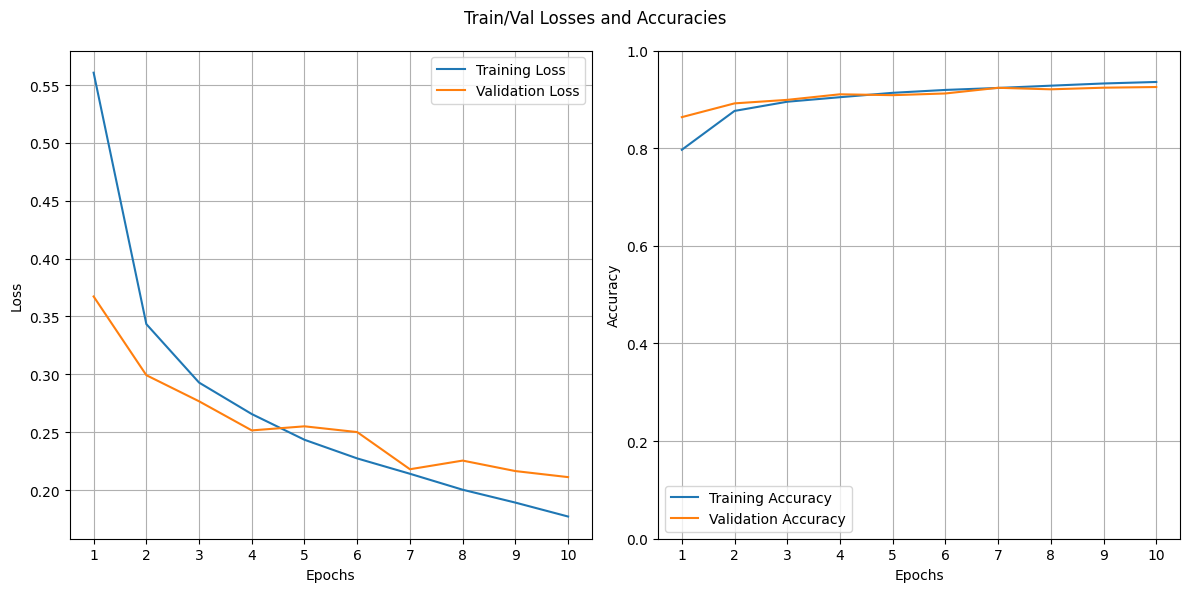

In [11]:
n_epochs = 10
lr = 0.001

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
plot_loss_curve(n_epochs, train_losses, val_losses, train_accs, val_accs)

In [12]:
test_loss, test_acc, y_preds = eval(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

100%|██████████| 79/79 [00:00<00:00, 135.45it/s]

Test Loss: 0.2412, Test Accuracy: 0.9135


### Grad-CAM Implementation

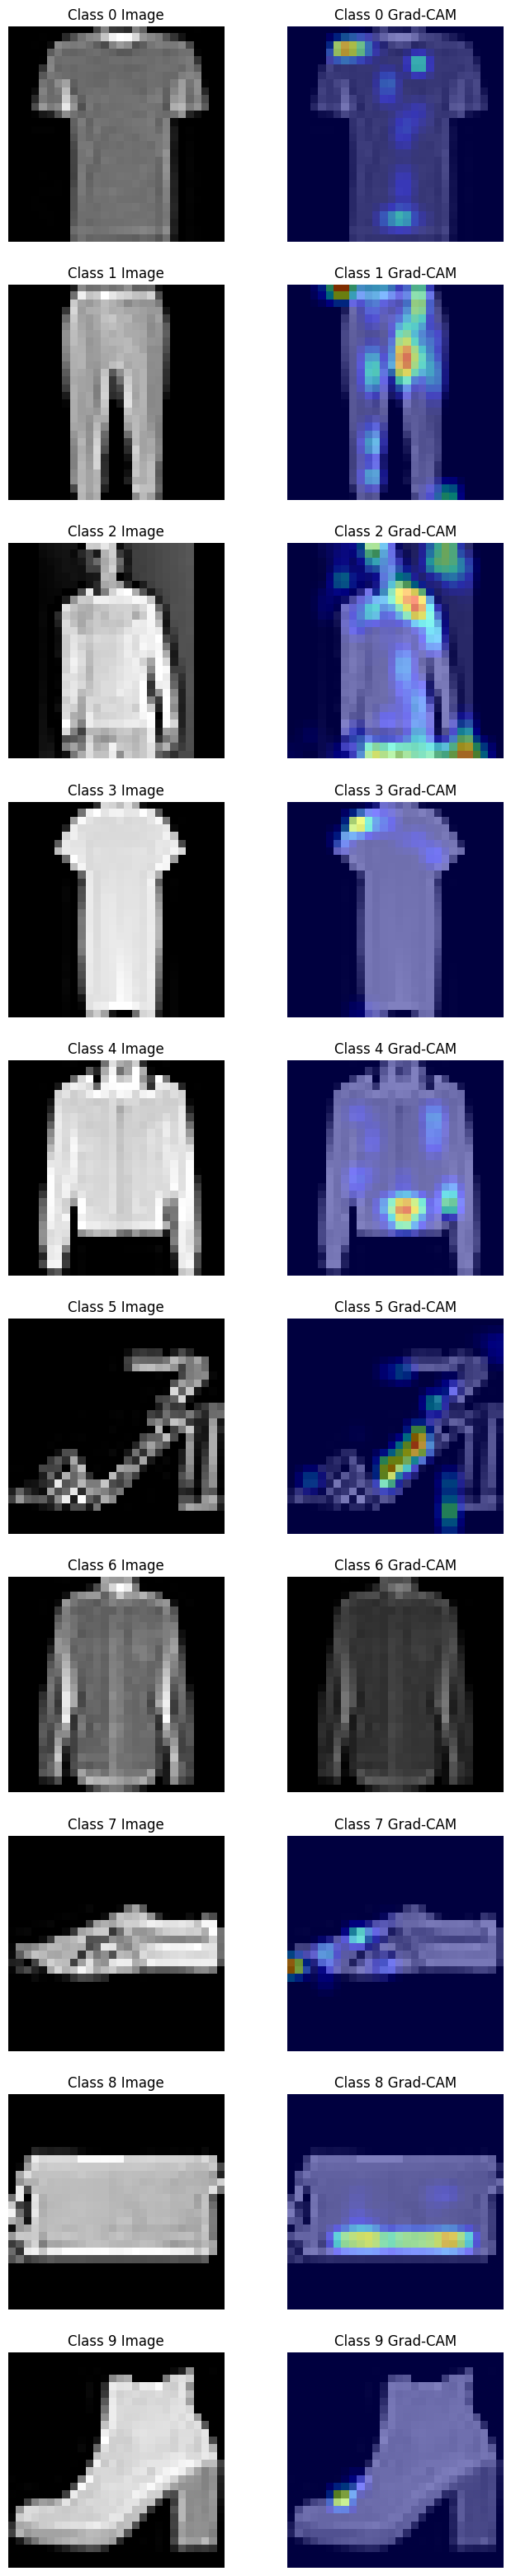

In [13]:
def hook_store_A(module, input, output):
    module.A = output[0]

def hook_store_dydA(module, grad_input, grad_output):
    module.dydA = grad_output[0]

layer = model.conv3

layer.register_forward_hook(hook_store_A)
layer.register_full_backward_hook(hook_store_dydA)

n_classes = 10
fig, ax = plt.subplots(nrows=n_classes, ncols=2, figsize=(8, n_classes*4))

for c in range(n_classes):
    for img, label in train_data:
        if label == c:
            break
        
    input = img.unsqueeze(0).to(device)

    output = model(input)

    model.zero_grad()
    output[0, label].backward()

    alpha = layer.dydA.mean((2, 3), keepdim=True)
    L = torch.relu((alpha * layer.A).sum(1, keepdim=True))

    L = L / L.max()
    L = F.interpolate(L, size=(input.size(2), input.size(3)),
                    mode='bilinear', align_corners=False)
    l = L.view(L.size(2), L.size(3)).detach().cpu().numpy()

    original_img = img.squeeze().cpu().numpy()
    heatmap = cm.jet(l)[:, :, :3]

    ax[c, 0].imshow(original_img, cmap='gray')
    ax[c, 0].set_title(f'Class {c} Image')
    ax[c, 0].axis('off')

    ax[c, 1].imshow(original_img, cmap='gray')
    ax[c, 1].imshow(heatmap, alpha=0.5)
    ax[c, 1].set_title(f'Class {c} Grad-CAM')
    ax[c, 1].axis('off')

plt.tight_layout
plt.show()

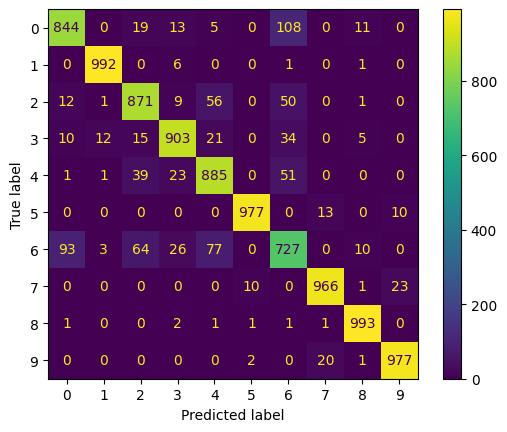

In [14]:
conf_matrix = confusion_matrix(test_data.targets.cpu().numpy(), y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

### Analysis

**DISCLAIMER**: The analysis below was made for a different run and does not match the output of the Grad-CAM anymore!

The model achieves a test accuracy of ~91%, demonstrating strong overall performance.\
Below is a breakdown of how the model attends to different classes, based on Grad-CAM visualizations and the confusion matrix:

- C0 (T-Shirt): The attention is scattered around the chest and shoulders, leading to confusion with label 6 (Unidentifiable). This suggests that the model struggles to distinguish t-shirts from ambiguous or less-defined items of clothing

- C1 (Pants): The model focuses on the legs, which aligns well with the correct features for classification. According to the confusion matrix, this class has the highest accuracy
- C2 (Pullover): The attention is centered on the body area, which seems appropriate given the confusion matrix results
- C3 (Dress): The model primarily focuses on the left shoulder, which appears suboptimal. It frequently misclassifies dresses as shirts, pants, pullovers, jackets, or label 6
- C4 (Jacket): The model focuses on the sleeves, which seems reasonable. However, it sometimes confuses jackets with pullovers and label 6
- C5 (Sandal): Surprisingly, the attention is directed toward the background rather than the sandal itself. Despite this, the model achieves near-perfect accuracy, possibly because other clothings occupy more space at the top and bottom of the image. This issue could potentially be mitigated through data augmentation (e.g., shifting images vertically)
- C6 (Unidentifiable): This class is challenging not only for the model but also for humans. Given its ambiguity, it is unsurprising that the model confuses it with t-shirts, pullovers, and jackets
- C7 (Sneaker): The model primarily attends to the background near the bottom of the shoe, with some attention on the laces. Despite this, it achieves the second-highest accuracy among all classes
- C8 (Bag): The model focuses on the intersection between the shoulder strap and the bag, allowing it to achieve the fourth-best accuracy overall
- C9 (Boots): The model’s attention is mainly on the background in the top-right corner, occasionally leading to misclassification as a sneaker

**General Observations**\
Across footwear categories (sandal, sneaker, boot), the model tends to focus on the background rather than the shoes themselves. This pattern suggests that background cues may play a role in classification, potentially introducing biases. Addressing this issue through data augmentation or background normalization could improve the model’s robustness.